In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools 
import datetime as dt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV


warnings.simplefilter("ignore")
pd.set_option('display.max_rows', 500)

In [2]:
data = pd.read_csv("RealTimeConsumption-01012016-21112019.csv")
# Converting Date column to datetime object
data['Date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y').dt.strftime('%Y-%m-%d')
# Renaming columns
data.columns = ['Date', 'Hour', 'Consumption']
# Removing commas (corresponds orders) from float values
data['Consumption'] = data['Consumption'].str.replace(',', '').astype(float)

In [3]:
# First 5 observations
data.head(5)

,Date,Hour,Consumption
0,2016-01-01,00:00,26277.24
1,2016-01-01,01:00,24991.82
2,2016-01-01,02:00,23532.61
3,2016-01-01,03:00,22464.78
4,2016-01-01,04:00,22002.91


## Cleaning the Data

In [4]:
# Finding each days and looking for the jumps between days, each should be one 
# But there's a jump for 2016-03-28 
unique_days = data.loc[data['Hour'] == '00:00', 'Date'].reset_index(drop=True)
unique_days = unique_days.apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
unique_days.shift(1).subtract(unique_days).sort_values()

86     -2 days
1      -1 days
951    -1 days
950    -1 days
949    -1 days
         ...  
470    -1 days
469    -1 days
445    -1 days
1419   -1 days
0          NaT
Name: Date, Length: 1420, dtype: timedelta64[ns]

In [5]:
# We can see that there is a jump for 86th day, which is 2016-03-28
unique_days[86]

Timestamp('2016-03-28 00:00:00')

In [6]:
# Checking the missing data (to keep data short, I only looked for first 4 hours)
data[(data['Date'] >= '2016-03-26') & (data['Date'] <= '2016-03-28') & (data['Hour'] < '04:00')]

,Date,Hour,Consumption
2040,2016-03-26,00:00,28413.30
2041,2016-03-26,01:00,26943.57
2042,2016-03-26,02:00,25841.11
2043,2016-03-26,03:00,25169.91
2064,2016-03-28,00:00,27358.43
2065,2016-03-28,01:00,25456.57
2066,2016-03-28,02:00,24328.06
2067,2016-03-28,03:00,23678.54


In [7]:
# Filling missing date with the previous values consumption values
last_week_consumption = data[data['Date'] == '2016-03-20'].replace('2016-03-20', '2016-03-27')
data = pd.concat([data, last_week_consumption])
data = data.sort_values(['Date', 'Hour']).reset_index(drop=True)

In [8]:
# After concatenating
data[(data['Date'] >= '2016-03-26') & (data['Date'] <= '2016-03-28') & (data['Hour'] < '04:00')]

,Date,Hour,Consumption
2040,2016-03-26,00:00,28413.30
2041,2016-03-26,01:00,26943.57
2042,2016-03-26,02:00,25841.11
2043,2016-03-26,03:00,25169.91
2064,2016-03-27,00:00,27580.31
2065,2016-03-27,01:00,25826.71
2066,2016-03-27,02:00,24546.43
2067,2016-03-27,03:00,23700.46
2088,2016-03-28,00:00,27358.43
2089,2016-03-28,01:00,25456.57


## a) Naive Approach

In [9]:
# Adding lagged values by shifting dataframe's columns and concatenating them
data = pd.concat([data, 
                  data[['Consumption']].shift(48), 
                  data[['Consumption']].shift(168)], axis=1)
data.columns = ['Date', 'Hour', 'Consumption', 'Consumption_Lag48', 'Consumption_Lag168']
data.tail()

,Date,Hour,Consumption,Consumption_Lag48,Consumption_Lag168
34099,2019-11-21,19:00,37946.52,37592.52,36943.60
34100,2019-11-21,20:00,37062.76,36855.44,36263.63
34101,2019-11-21,21:00,36151.79,35835.72,35254.77
34102,2019-11-21,22:00,35128.32,34726.53,34154.07
34103,2019-11-21,23:00,33776.82,33501.29,32646.61


In [10]:
# Splitting train and test data from 1 November 2019
test = data[data['Date'] >= '2019-11-01']
train = data[data['Date'] < '2019-11-01']
print(len(test), len(train))

504 33600


In [11]:
# Removing NA or missing values from the data
train = train.dropna()
test = test[test['Consumption'] > 0]
test.head()

,Date,Hour,Consumption,Consumption_Lag48,Consumption_Lag168
33600,2019-11-01,00:00,29417.56,27154.21,29563.43
33601,2019-11-01,01:00,28133.75,26157.42,28242.90
33602,2019-11-01,02:00,27358.60,25373.88,27258.74
33603,2019-11-01,03:00,26780.09,24911.43,26739.84
33604,2019-11-01,04:00,26511.54,24836.11,26555.35


In [12]:
def calculate_mape(actual_col, predicted_col):
  actual_col, predicted_col = np.array(actual_col), np.array(predicted_col)
  assert len([i for i in actual_col if i <= 0]) == 0, \
    "There are nonpositive values in actual column, consider dropping those observations from the data."
  return (np.mean(np.abs((actual_col - predicted_col) / actual_col)) * 100, 
          np.abs((actual_col - predicted_col) / actual_col))

In [13]:
answer_a_2, list_a_2 = calculate_mape(test['Consumption'], test['Consumption_Lag48'])
print(answer_a_2)

7.773674356597642


In [14]:
answer_a_7, list_a_7 = calculate_mape(test['Consumption'], test['Consumption_Lag168'])
print(answer_a_7)

2.8368325260650877


## b) Linear Regression

In [15]:
def linear_reg_fnc(train_data, test_data, X, y, return_val=False):
  train_X, train_y = train_data[X], train_data[y]
  test_X, test_y = test_data[X], test_data[y]
  reg = LinearRegression().fit(train_X, train_y)
  predicted = reg.predict(test_X)
  actual = np.array(test_y)
  print(''.format(
    reg.coef_[0][0], reg.coef_[0][1], reg.intercept_[0]))
  mape, result_list = calculate_mape(actual, predicted)
  print('MAPE is {}'.format(mape))
  print('{} = {} + {}'.format(y[0], np.round(reg.intercept_[0], 4),
                              ' + '.join(['{} * {}'.format(np.round(reg.coef_[0][i], 4), x) 
                                          for i,x in enumerate(X)])))
  if return_val:
    return mape, result_list

In [16]:
answer_b, list_b = linear_reg_fnc(train, test, ['Consumption_Lag48', 'Consumption_Lag168'], ['Consumption'], return_val=True)
list_b = list(itertools.chain.from_iterable(list_b))


MAPE is 4.003013991176448
Consumption = 1610.3746 + 0.3241 * Consumption_Lag48 + 0.6265 * Consumption_Lag168


## c) Analyzing each hour seperately

In [17]:
hour_list = train['Hour'][:24].tolist()
mape_list_c, list_c = [], []
for hour in hour_list:
  result = linear_reg_fnc(train[train['Hour'] == hour], 
                 test, 
                 X=['Consumption_Lag48', 'Consumption_Lag168'], 
                 y=['Consumption'],
                 return_val=True)
  mape_list_c.append(result[0])
  list_c.append(list(itertools.chain.from_iterable(result[1])))
  
  print('\n')

list_c = list(itertools.chain.from_iterable(list_c))


MAPE is 5.153399727337642
Consumption = 2388.0149 + 0.5022 * Consumption_Lag48 + 0.4207 * Consumption_Lag168



MAPE is 5.248946857412524
Consumption = 2306.2164 + 0.5064 * Consumption_Lag48 + 0.4152 * Consumption_Lag168



MAPE is 5.356381534144769
Consumption = 2368.8418 + 0.5081 * Consumption_Lag48 + 0.4082 * Consumption_Lag168



MAPE is 5.397561401690561
Consumption = 2416.3434 + 0.5009 * Consumption_Lag48 + 0.4115 * Consumption_Lag168



MAPE is 5.338043421720102
Consumption = 2444.3568 + 0.4821 * Consumption_Lag48 + 0.4282 * Consumption_Lag168



MAPE is 5.215327161450597
Consumption = 2646.4571 + 0.4448 * Consumption_Lag48 + 0.4575 * Consumption_Lag168



MAPE is 4.843419685947041
Consumption = 2656.5939 + 0.3749 * Consumption_Lag48 + 0.5273 * Consumption_Lag168



MAPE is 4.183418177165774
Consumption = 2901.9863 + 0.2645 * Consumption_Lag48 + 0.6338 * Consumption_Lag168



MAPE is 3.5235461644925206
Consumption = 3974.0943 + 0.1743 * Consumption_Lag48 + 0.7021 * Consumption_

In [18]:
# training with only same hours data

for hour in hour_list:
  print('Hour: {}'.format(hour))
  linear_reg_fnc(train[train['Hour'] == hour], 
               test[test['Hour'] == hour], 
                 X=['Consumption_Lag48', 'Consumption_Lag168'], 
                 y=['Consumption'])
  print('\n')

Hour: 00:00

MAPE is 3.122243108427619
Consumption = 2388.0149 + 0.5022 * Consumption_Lag48 + 0.4207 * Consumption_Lag168


Hour: 01:00

MAPE is 3.334429865534528
Consumption = 2306.2164 + 0.5064 * Consumption_Lag48 + 0.4152 * Consumption_Lag168


Hour: 02:00

MAPE is 3.355814935728315
Consumption = 2368.8418 + 0.5081 * Consumption_Lag48 + 0.4082 * Consumption_Lag168


Hour: 03:00

MAPE is 3.275349481051059
Consumption = 2416.3434 + 0.5009 * Consumption_Lag48 + 0.4115 * Consumption_Lag168


Hour: 04:00

MAPE is 3.2434181494119065
Consumption = 2444.3568 + 0.4821 * Consumption_Lag48 + 0.4282 * Consumption_Lag168


Hour: 05:00

MAPE is 3.2440466184708985
Consumption = 2646.4571 + 0.4448 * Consumption_Lag48 + 0.4575 * Consumption_Lag168


Hour: 06:00

MAPE is 3.4749836539398262
Consumption = 2656.5939 + 0.3749 * Consumption_Lag48 + 0.5273 * Consumption_Lag168


Hour: 07:00

MAPE is 3.936829678778744
Consumption = 2901.9863 + 0.2645 * Consumption_Lag48 + 0.6338 * Consumption_Lag168


Hour:

## d) Wide format, lasso

In [19]:
data.head()

,Date,Hour,Consumption,Consumption_Lag48,Consumption_Lag168
0,2016-01-01,00:00,26277.24,NaN,NaN
1,2016-01-01,01:00,24991.82,NaN,NaN
2,2016-01-01,02:00,23532.61,NaN,NaN
3,2016-01-01,03:00,22464.78,NaN,NaN
4,2016-01-01,04:00,22002.91,NaN,NaN


In [20]:
data_wide = data.pivot(index='Date', columns='Hour', values=['Consumption_Lag48', 'Consumption_Lag168'])
data_wide.columns = ['Lag_day_{}_hour_{}'.format(i, j) for i in (2, 7) for j in range(24)]
data_wide = data_wide.dropna().reset_index()
data_wide.head()

,Date,Lag_day_2_hour_0,Lag_day_2_hour_1,Lag_day_2_hour_2,Lag_day_2_hour_3,Lag_day_2_hour_4,Lag_day_2_hour_5,Lag_day_2_hour_6,Lag_day_2_hour_7,Lag_day_2_hour_8,...,Lag_day_7_hour_14,Lag_day_7_hour_15,Lag_day_7_hour_16,Lag_day_7_hour_17,Lag_day_7_hour_18,Lag_day_7_hour_19,Lag_day_7_hour_20,Lag_day_7_hour_21,Lag_day_7_hour_22,Lag_day_7_hour_23
0,2016-01-08,29189.27,27614.02,26578.97,25719.19,25864.63,25918.59,27091.94,28533.05,33203.34,...,29548.32,29390.89,30734.97,32048.02,31438.11,30728.47,30166.14,29461.28,29242.83,28069.09
1,2016-01-09,28763.95,27284.84,26321.95,25748.49,25636.58,25932.52,26963.74,28444.83,32804.27,...,32796.18,32594.55,33358.47,34387.95,33591.26,32648.83,31897.73,31049.20,30906.43,29621.09
2,2016-01-10,28602.02,27112.37,25975.34,25315.55,25128.15,25356.22,26338.72,28086.42,32702.24,...,31056.47,30979.53,32297.46,33462.96,33151.03,32450.21,32093.93,31315.16,31014.19,29462.06
3,2016-01-11,29906.93,28061.98,26808.78,25798.80,25820.46,26035.77,26451.24,26853.42,30627.32,...,39661.98,39211.00,39760.12,39633.29,37621.41,35954.18,35114.12,34066.40,33686.83,31733.54
4,2016-01-12,28890.37,27133.75,25656.13,24937.87,24538.16,24616.05,24478.14,23813.35,24676.92,...,38086.11,37834.89,38599.34,38669.63,36954.78,35306.11,34301.59,33400.82,33359.37,31629.97


In [21]:
# TO SEE CORR MATRIX, WHITER COLOR MEANS MORE SIMILAR

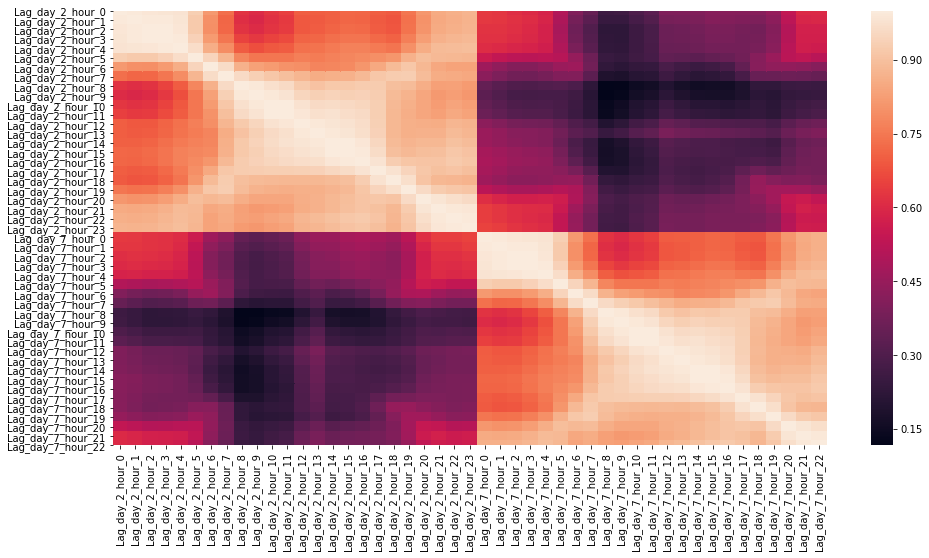

In [22]:
corr = data_wide.iloc[:,1:-1].corr()

fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns)

In [23]:
mape_list_d, list_d = [], []
for hour in hour_list:
  train_X = data_wide[data_wide['Date'] < '2019-11-01'].iloc[:,1:]
  test_X = data_wide[data_wide['Date'] >= '2019-11-01'].iloc[:,1:]
  train_y = np.ravel(data.loc[(data['Date'].isin(data_wide[data_wide['Date'] < '2019-11-01'].Date)) & (data['Hour'] == hour), 'Consumption'])
  test_y = np.ravel(data.loc[(data['Date'].isin(data_wide[data_wide['Date'] >= '2019-11-01'].Date)) & (data['Hour'] == hour), 'Consumption'])
  reg = LassoCV(cv=10, normalize=True, tol=0.001, 
                selection='random', random_state=43,
                alphas=np.logspace(-4, 2, 100))
  reg.fit(train_X, train_y)
  output_tuple = calculate_mape(reg.predict(test_X), test_y)
  mape_list_d.append(output_tuple[0])
  list_d.append(output_tuple[1])

  print('For {} hour, column with max coefficient is {}'
        .format(hour, train_X.columns[np.argmax(reg.coef_)]))
  # fig, ax = plt.subplots(figsize=(12,8))
  # sns.barplot(x=X.columns, y=reg.coef_, color='c')
  # plt.xticks(rotation=90)
  # plt.title(hour)
  # plt.show()

list_d = list(itertools.chain.from_iterable(list_d))

For 00:00 hour, column with max coefficient is Lag_day_2_hour_23
For 01:00 hour, column with max coefficient is Lag_day_2_hour_23
For 02:00 hour, column with max coefficient is Lag_day_2_hour_23
For 03:00 hour, column with max coefficient is Lag_day_2_hour_23
For 04:00 hour, column with max coefficient is Lag_day_2_hour_23
For 05:00 hour, column with max coefficient is Lag_day_2_hour_23
For 06:00 hour, column with max coefficient is Lag_day_2_hour_23
For 07:00 hour, column with max coefficient is Lag_day_7_hour_7
For 08:00 hour, column with max coefficient is Lag_day_2_hour_13
For 09:00 hour, column with max coefficient is Lag_day_2_hour_13
For 10:00 hour, column with max coefficient is Lag_day_2_hour_13
For 11:00 hour, column with max coefficient is Lag_day_2_hour_13
For 12:00 hour, column with max coefficient is Lag_day_2_hour_13
For 13:00 hour, column with max coefficient is Lag_day_2_hour_13
For 14:00 hour, column with max coefficient is Lag_day_2_hour_13
For 15:00 hour, column wit

For hours 19:00 - 06:00 lag_day_2_hour_23 is the most important element.
 08:00-18:00 lag_day_2_hour_13
 for 07:00 hour, lag_day_7_hour_7
 
We can understand that consumption at 7 am is directly affected from weekdays. Weekday's consumption is probably higher than weekend's since people usually wakes up earlier in the weekdays. Other than 7th hour, morning hours are mostly determined by 13th hour of 2 days before and night hours are determined by 23th hour of 2 days before.

# e

In [24]:
# couldn't make this part, just a beginning
# import cvxpy as cp
# from cvxpy.atoms.affine.diff import diff

# def loss_fn(X, Y, beta):
#     return cp.norm2(cp.matmul(X, beta) - Y)**2

# def regularizer(beta):
#     return cp.norm1(beta)

# def fused_penalty(beta):
#     return cp.norm1(diff(beta))

# def objective_fn(X, Y, beta, lambd1, lambd2):
#     return loss_fn(X, Y, beta) + lambd1 * regularizer(beta) + lambd2 * fused_penalty(beta)

# def mse(X, Y, beta):
#     return (1.0 / X.shape[0]) * loss_fn(X, Y, beta).value

# f

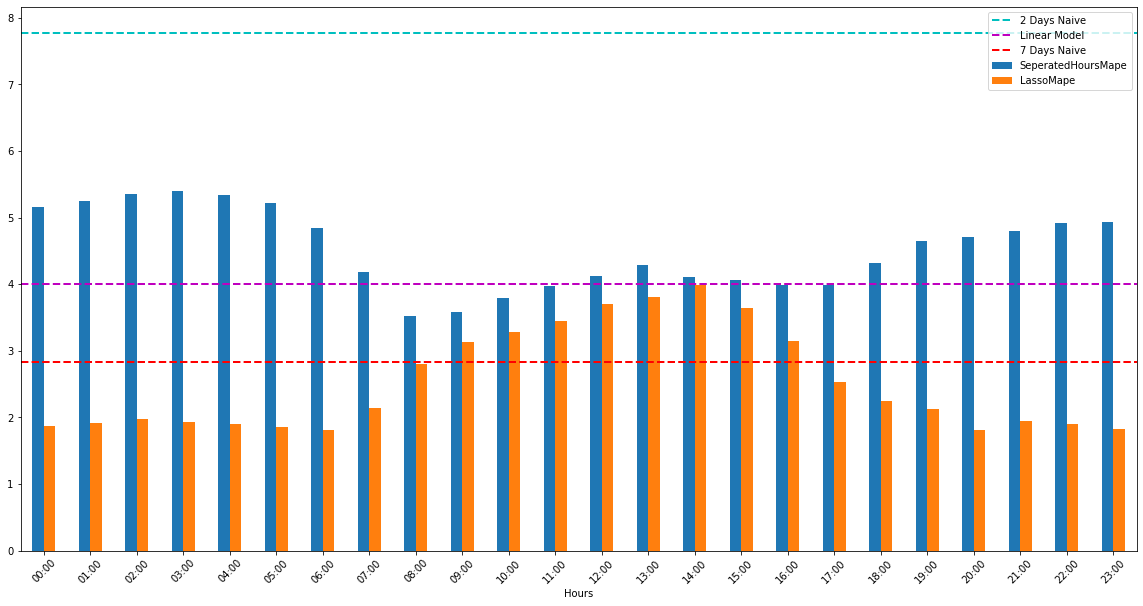

In [25]:
pd.DataFrame.from_dict({'Hours': hour_list,
                        'SeperatedHoursMape': mape_list_c,
                        'LassoMape': mape_list_d}).set_index('Hours').plot(kind='bar', figsize=(20,10))
plt.axhline(answer_a_2, color='c', linestyle='--', linewidth=2, label='2 Days Naive')
plt.axhline(answer_b, color='m', linestyle='--', linewidth=2, label='Linear Model')
plt.axhline(answer_a_7, color='r', linestyle='--', linewidth=2, label='7 Days Naive')
plt.legend()
plt.xticks(rotation=45)
plt.show()

We can see that best values can be reached with Lasso model, especially for the night time, the model is doing really great. But for the day times 7 days naive approach works better than anything else in our example. This can be interpreted like this, reasons behind the variations in consumption values are number of people working, temperature and so on. These factors are directly related with day of week and hour of the day, so naive approach can learn this "simple" model pretty well, of course there are better approaches than this naive approach but regression models as these might complicate our problem by deducing extra meanings between features. This might be related with correlation of features or weights of the features.

In [26]:
len(list_a_2), len(list_a_7), len(list_b), len(list_c), len(list_d)

(504, 504, 504, 12096, 504)

In [27]:
boxplot_df = pd.DataFrame({'2DaysNaive': pd.Series(list_a_2), 
                          '7DaysNaive': pd.Series(list_a_7),
                          'SeperatedHoursMape': pd.Series(list_b),
                          'LinearModel': pd.Series(list_c),
                          'Lasso': pd.Series(list_d)})


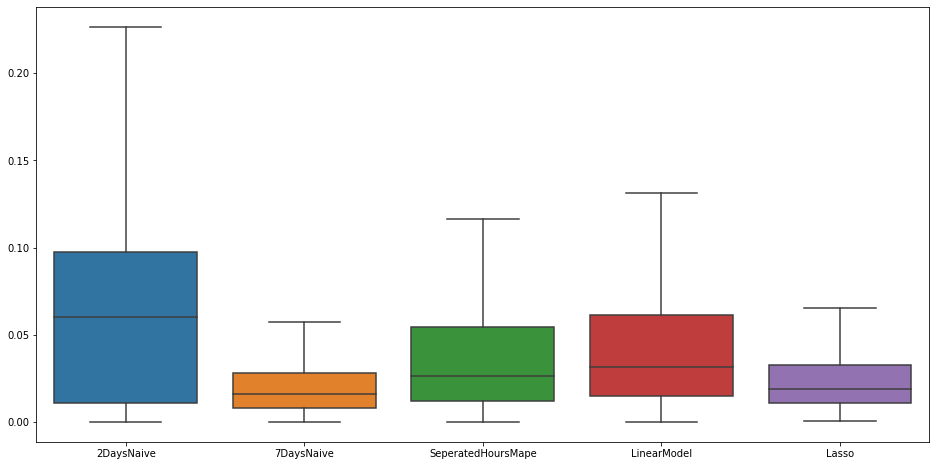

In [29]:
# I am not displaying outlier points since the number of observations are different for 
# the first 3 model and remaining because of the hours dimension introduced
fig, ax = plt.subplots(figsize=(16,8))
sns.boxplot(data=boxplot_df, showfliers=False)